Pose Tracking from mp4 with AlphaPose
==========================================================

This code extracts images from video then uses pre-trained Alpha Pose models to capture tracking data.


1. Load Packages
==========================================================

First let's import some necessary libraries:

In [2]:

%matplotlib inline
from matplotlib import pyplot as plt
from gluoncv import model_zoo, data, utils
from gluoncv.data.transforms.pose import detector_to_alpha_pose, heatmap_to_coord_alpha_pose
from ipywidgets import interact
import ffmpeg
import ipywidgets as widgets
import numpy as np
import subprocess
import pandas as pd
import cv2 as cv
from PIL import Image


Now bring in the video and figure out width and height

In [3]:

Dunk = ffmpeg.probe('Dunk.mp4')
video_info = next(s for s in Dunk['streams'] if s['codec_type'] == 'video')
width = int(video_info['width'])
height = int(video_info['height'])
num_frames = int(video_info['nb_frames'])
def get_length(input_video):
    result = subprocess.run(['ffprobe', '-v', 'error', '-show_entries', 'format=duration', '-of', 'default=noprint_wrappers=1:nokey=1', input_video], stdout=subprocess.PIPE, stderr=subprocess.STDOUT)
    return float(result.stdout)
time = get_length('Dunk.mp4')

print('Width: ', width)
print('Height: ',height)
print('Frames: ',num_frames)
print('Time: ',time)


Width:  1280
Height:  720
Frames:  203
Time:  6.803


In [3]:

i = 0.1

while i < time: 
    string_in_string = "output{}.jpg".format(i)
    (
        ffmpeg
        .input('Dunk.mp4', ss=i)
        .filter('scale', width, -1)
        .output(string_in_string, vframes=1)
        .run()
    )
    i = i + 0.5


Load a pretrained model
-------------------------

Let's get a Alpha Pose model trained with input images of size 256x192 on MS COCO
dataset. We pick the one using ResNet-101 V1b as the base model. By specifying
``pretrained=True``, it will automatically download the model from the model
zoo if necessary. For more pretrained models, please refer to
:doc:`../../model_zoo/index`.

Note that a Alpha Pose model takes a top-down strategy to estimate
human pose in detected bounding boxes from an object detection model.



In [4]:

detector = model_zoo.get_model('yolo3_mobilenet1.0_coco', pretrained=True)
pose_net = model_zoo.get_model('alpha_pose_resnet101_v1b_coco', pretrained=True)

# Note that we can reset the classes of the detector to only include
# human, so that the NMS process is faster.

detector.reset_class(["person"], reuse_weights=['person'])


Display and write out jpg for the pose estimation results
---------------------

Use :py:func:`gluoncv.utils.viz.plot_keypoints` to visualize the
results.

Note: 
Pred_coords is an mxnet.nDArray. I change it into a numpy array and then pandas data frame, 

However, that may take up a bunch of processing time I don't need.



             0        1          2           3           4          5  \
0   266.402344  493.875  89.058594  656.140625  510.550781  40.895836   
1   258.855469  493.875  98.128906  656.921875  511.652344  26.270834   
2   263.167969  493.125  89.058594  693.640625  519.363281  40.895836   
3   257.777344  496.125  77.972656  657.703125  510.550781  27.354168   
4   265.324219  501.375  89.058594  664.734375  521.566406  38.729168   
5   255.082031  501.375  69.910156  658.484375  507.246094  14.354167   
6   266.402344  505.875  90.066406  668.640625  523.769531  34.937500   
7   247.535156  502.875  61.847656  658.484375  501.738281   5.687500   
8   268.558594  509.625  92.082031  674.890625  529.277344  39.270836   
9   250.769531  499.125  60.839844  648.328125  497.332031  36.020836   
10  268.558594  498.375  99.136719  665.515625  502.839844  46.854168   
11  251.847656  505.125  69.910156  665.515625  508.347656   4.604167   
12  258.855469  505.875  85.027344  672.546875  516

             0           1           2           3          4
0    95.351562  369.964844  382.722656  201.480469  48.609375
1   108.148438  370.894531  383.800781  202.214844  32.140625
2    96.335938  378.332031  382.183594  200.378906  49.140625
3    84.523438  373.683594  386.496094  202.949219  31.078125
4    94.367188  382.980469  382.722656  198.910156  42.765625
5    74.679688  366.246094  391.886719  206.988281  18.859375
6    96.335938  384.839844  385.957031  197.808594  40.109375
7    66.804688  356.949219  392.425781  208.824219  10.359375
8    98.304688  387.628906  382.183594  195.972656  41.703125
9    69.757812  366.246094  383.800781  208.457031  40.640625
10  105.195312  380.191406  374.636719  197.074219  34.265625
11   71.726562  362.527344  403.207031  206.621094   5.578125
12   87.476562  375.542969  397.277344  200.746094  25.234375
13   69.757812  351.371094  389.191406  206.988281  25.765625
14   98.304688  372.753906  387.574219  201.480469  44.890625
15   64.

             0           1           2           3          4           5  \
0   352.347656  597.976562  447.832031  280.285156  226.84375  158.652344   
1   373.371094  598.929688  449.285156  286.769531  238.09375  162.214844   
2   357.832031  601.789062  449.285156  289.363281  227.78125  180.027344   
3   350.519531  599.882812  451.464844  279.636719  217.46875  161.769531   
4   359.660156  606.554688  450.011719  290.011719  227.78125  172.011719   
5   353.261719  598.929688  457.277344  270.558594  211.84375  154.644531   
6   366.058594  608.460938  452.191406  293.902344  233.40625  175.128906   
7   352.347656  598.929688  465.996094  266.667969  209.03125  151.972656   
8   374.285156  617.039062  453.644531  301.035156  239.96875  181.808594   
9   348.691406  590.351562  456.550781  283.527344  204.34375  160.878906   
10  372.457031  607.507812  450.011719  297.792969  240.90625  181.808594   
11  362.402344  606.554688  461.636719  267.964844  215.59375  155.089844   

             0           1           2           3        4           5  \
0   676.511719  349.804688  206.230469  537.378906  580.625  214.476562   
1   677.933594  348.523438  207.277344  538.152344  582.125  214.929688   
2   677.222656  352.367188  206.230469  537.378906  579.875  233.507812   
3   680.777344  340.835938  193.667969  542.019531  587.375  216.742188   
4   675.089844  350.445312  204.136719  538.925781  587.375  226.257812   
5   683.621094  330.585938  187.910156  546.660156  588.125  210.398438   
6   681.488281  354.289062  206.230469  538.925781  588.125  232.601562   
7   685.753906  326.742188  186.863281  552.074219  597.125  209.492188   
8   680.777344  359.414062  208.847656  536.605469  594.875  241.210938   
9   684.332031  352.367188  198.902344  550.527344  600.125  241.664062   
10  675.089844  365.179688  206.753906  531.191406  586.625  234.414062   
11  681.488281  325.460938  185.816406  545.113281  592.625  212.664062   
12  680.066406  344.03906

            0          1           2         3           4           5  \
0   631.40625  643.28125  212.929688  514.3125  192.792969  348.566406   
1   632.09375  644.65625  212.132812  516.0625  194.558594  334.300781   
2   630.71875  641.90625  219.304688  514.3125  202.503906  343.378906   
3   625.21875  647.40625  211.335938  519.5625  193.675781  334.949219   
4   627.28125  641.90625  220.101562  516.0625  202.503906  345.324219   
5   623.84375  652.21875  211.335938  527.4375  190.144531  327.816406   
6   621.09375  639.84375  229.664062  510.8125  209.566406  352.457031   
7   622.46875  654.96875  207.351562  531.8125  180.433594  327.816406   
8   616.96875  637.78125  234.445312  506.4375  221.042969  360.886719   
9   627.28125  654.28125  203.367188  534.4375  186.613281  341.433594   
10  624.53125  639.84375  228.867188  501.1875  215.746094  356.996094   
11  620.40625  648.09375  218.507812  523.9375  193.675781  330.410156   
12  619.03125  643.96875  231.257812  

             0          1       2           3           4           5  \
0   544.007812  162.53125  194.75  255.707031  343.531250  237.613281   
1   546.585938  169.09375  196.25  269.808594  371.239594  242.535156   
2   543.148438  159.71875  206.75  274.261719  346.447906  237.613281   
3   550.023438  151.28125  197.25  266.839844  333.322906  227.277344   
4   542.289062  160.65625  208.25  273.519531  343.531250  236.628906   
5   554.320312  143.78125  191.25  261.644531  326.031250  219.402344   
6   537.992188  163.46875  210.75  267.582031  349.364594  238.597656   
7   556.898438  140.03125  189.75  258.675781  329.677094  215.957031   
8   530.257812  169.09375  218.25  260.902344  369.052094  244.996094   
9   558.617188  136.28125  204.25  271.292969  346.447906  223.339844   
10  528.539062  173.78125  214.75  266.839844  368.322906  243.027344   
11  547.445312  149.40625  188.75  252.738281  332.593750  217.925781   
12  536.273438  163.46875  200.75  257.191406  348.

             0           1           2           3           4           5  \
0   194.160156  237.960938  248.949219  166.417969  710.339844  577.007812   
1   193.652344  243.289062  250.847656  166.417969  711.824219  578.914062   
2   213.964844  238.445312  248.316406  166.417969  710.339844  575.101562   
3   196.191406  227.789062  252.746094  156.949219  715.535156  582.726562   
4   206.855469  237.476562  247.683594  163.261719  710.339844  573.195312   
5   191.113281  219.070312  255.277344  149.058594  719.988281  588.445312   
6   209.902344  238.445312  245.152344  160.105469  708.855469  568.429688   
7   199.238281  216.164062  258.441406  150.636719  724.441406  593.210938   
8   218.027344  245.226562  237.558594  161.683594  706.628906  561.757812   
9   206.855469  225.367188  257.175781  164.050781  719.988281  587.492188   
10  218.535156  242.804688  228.066406  168.785156  702.175781  563.664062   
11  188.574219  218.585938  251.480469  149.058594  716.277344  

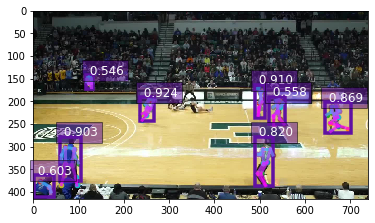

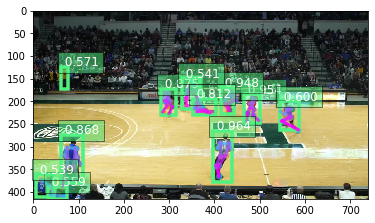

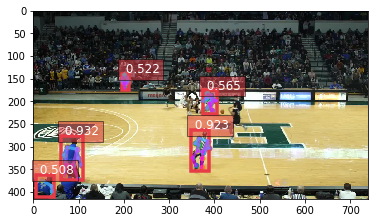

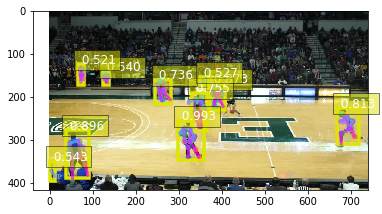

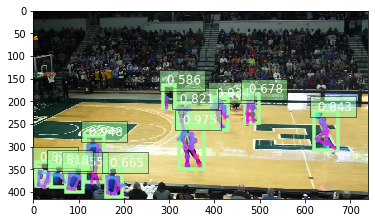

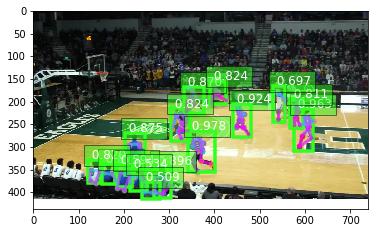

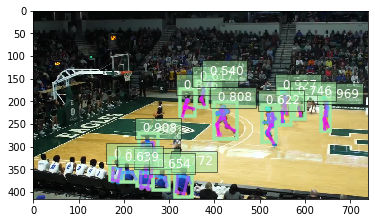

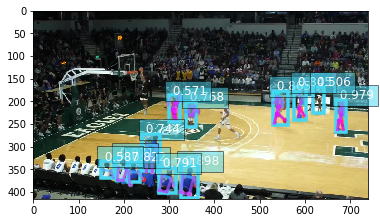

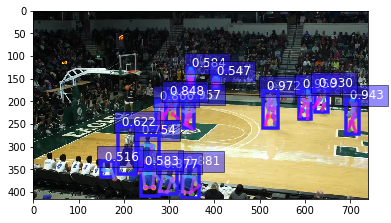

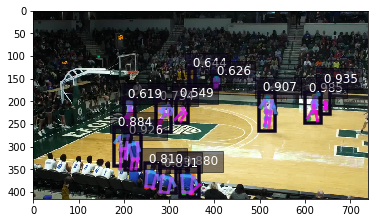

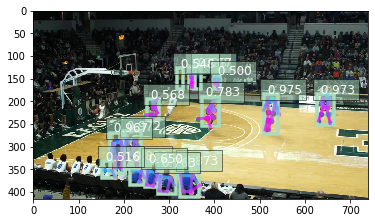

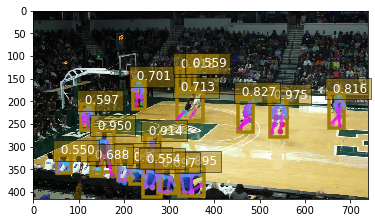

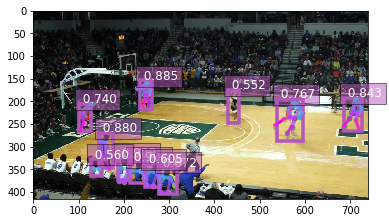

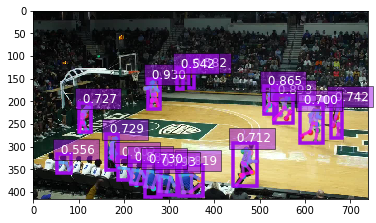

In [6]:

xtot = []
ytot = []

i = 0.1

while i < time:
# Read in each image and transform to necessary structure
    im_fname = "output{}.jpg".format(i)
    output = "outputa{}.jpg".format(i)
    x, img = data.transforms.presets.yolo.load_test(im_fname)
#    print('Shape of pre-processed image:', x.shape)
    class_IDs, scores, bounding_boxs = detector(x)
    pose_input, upscale_bbox = detector_to_alpha_pose(img, class_IDs, scores, bounding_boxs)
# Run AlphaPose
    predicted_heatmap = pose_net(pose_input)
    pred_coords, confidence = heatmap_to_coord_alpha_pose(predicted_heatmap, upscale_bbox)
# Visualize pose data
    ax = utils.viz.plot_keypoints(img, pred_coords, confidence, class_IDs, bounding_boxs, scores, box_thresh=0.5, keypoint_thresh=0.2)
# Change coordinates to numpy array, transpose into x and y coordinates, and then change into a pandas dataframe
    num_coords = pred_coords.asnumpy()
    x, y = num_coords.T
    x = pd.DataFrame(x)
    y = pd.DataFrame(y)
#    print(x)
#    print(y)
# Select only the coordinates we want (see list below)
    x = x.iloc[15]
    y = y.iloc[15]
    print(x)
    print(y)
# You can use this to check which points are what, change s for bigger points
#    plt.scatter(x,y,s=250) 
# Save the figure to a new jpg
#    plt.savefig(output)
    xtot.append(x)
    ytot.append(y)
    i = i + 0.5

#use: x = x.iloc[17]; y = y.iloc[17]; plt.scatter(x,y,s=500) to get overlay points points

#This is the COCO
#iloc[0] is Nose
#iloc[1] is L eye
#iloc[2] is R eye
#iloc[3] is L ear
#iloc[4] is R ear
#iloc[5] is L shoulder
#iloc[6] is R shoulder
#iloc[7] is L elbow
#iloc[8] is R elbow
#iloc[9] is L wrist
#iloc[10] is R wrist
#iloc[11] is L hip
#iloc[12] is R hip
#iloc[13] is L knee
#iloc[14] is R knee
#iloc[15] is L ankle
#iloc[16] is R ankle

#This will flip the axis to plot normally, but will screw it up if you plot it on the original image
#y = 416 - y


Write the frames back into a movie
---------------------

The python code below doesn't work for me, because the pattern_type 'glob' function doesn't work on Windows:
https://github.com/kkroening/ffmpeg-python/issues/180

So I just imported the jpgs into the Windows Photos App and saved a movie from there at 5 frames per second (2.5x playback).


In [44]:

#try: (
#    ffmpeg
#    .input('*.jpg', pattern_type='glob', framerate=25)
#    .output('movie.mp4')
#    .run(capture_stdout=True, capture_stderr=True)
#)
  

#This will read out the stderr
#except ffmpeg.Error as e:
#    print('stdout:', e.stdout.decode('utf8'))
#    print('stderr:', e.stderr.decode('utf8'))
#    raise e


Next Steps
---------------------

1. Save into a clean data frame
2. Run through poseflow to track people through frames
3. Scale coordinates to the court
4. Simplify the code to reduce run time

In [17]:

print(x)
print(type(x))
print(xtot)
print(type(xtot))


Image Template Matching
---------------------
Match


0.3144799768924713
0.3058582544326782


C:\Users\hubbb\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\hubbb\Anaconda3\lib\site-packages\ipykernel_launcher.py:58: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


0.37063002586364746


C:\Users\hubbb\Anaconda3\lib\site-packages\ipykernel_launcher.py:75: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


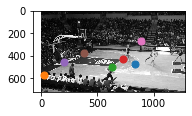

In [52]:

LArc = cv.imread('LArc.jpg',0)
LFT = cv.imread('LFT.jpg',0)
LBox = cv.imread('LBox.jpg',0)
E = cv.imread('E.jpg',0)

orig = cv.imread("output6.1.jpg",0)
col = Image.open("output6.1.jpg")
gray = col.convert('L')
bw = gray.point(lambda x: 0 if x < 230 else 255, '1')
bw.save("result_bw61.jpg")
img = cv.imread("result_bw61.jpg",0)

method = eval('cv.TM_CCOEFF_NORMED')

#Left Arc (LArc)
template = LArc
w, h = template.shape[::-1]
res = cv.matchTemplate(img,template,method)
min_val, max_val, min_loc, max_loc = cv.minMaxLoc(res)
print(max_val)
top_left = max_loc
bottom_right = (top_left[0] + w, top_left[1] + h)
cv.rectangle(img,top_left, bottom_right, 255, 2)
plt.subplot(122),plt.imshow(orig,cmap = 'gray')
L3x = top_left[0] + 23
L3y = top_left[1] + 301
T3x = top_left[0] + 835
T3y = top_left[1] + 196
plt.scatter(T3x,T3y,s=50) 
plt.scatter(L3x,L3y,s=50) 

#Left FT Line (LFT)
template = LFT
w, h = template.shape[::-1]
res = cv.matchTemplate(img,template,method)
min_val, max_val, min_loc, max_loc = cv.minMaxLoc(res)
print(max_val)
top_left = max_loc
bottom_right = (top_left[0] + w, top_left[1] + h)
cv.rectangle(img,top_left, bottom_right, 255, 2)
plt.subplot(122),plt.imshow(orig,cmap = 'gray')
LFTx = top_left[0] + 17
LFTy = top_left[1] + 88
RFTx = top_left[0] + 110
RFTy = top_left[1] + 10
plt.scatter(LFTx,LFTy,s=50) 
plt.scatter(RFTx,RFTy,s=50) 

#LBox
template = LBox
w, h = template.shape[::-1]
res = cv.matchTemplate(img,template,method)
min_val, max_val, min_loc, max_loc = cv.minMaxLoc(res)
print(max_val)
top_left = max_loc
bottom_right = (top_left[0] + w, top_left[1] + h)
cv.rectangle(img,top_left, bottom_right, 255, 2)
plt.subplot(122),plt.imshow(orig,cmap = 'gray')
LBx = top_left[0] + 61
LBy = top_left[1] + 98
RBx = top_left[0] + 240
RBy = top_left[1] + 18
plt.scatter(LBx,LBy,s=50) 
plt.scatter(RBx,RBy,s=50) 

#E
template = E
w, h = template.shape[::-1]
res = cv.matchTemplate(img,template,method)
min_val, max_val, min_loc, max_loc = cv.minMaxLoc(res)
print(max_val)
top_left = max_loc
bottom_right = (top_left[0] + w, top_left[1] + h)
cv.rectangle(img,top_left, bottom_right, 255, 2)
plt.subplot(122),plt.imshow(orig,cmap = 'gray')
Cx = top_left[0]+221
Cy = top_left[1]+71
plt.scatter(Cx,Cy,s=50) 
plt.show()




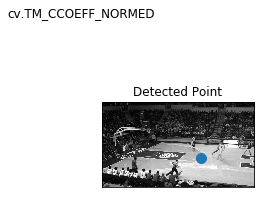

(0, 273)
1079
365


In [24]:

# Turn the image black and white - if it's close to white, turn it white, everything else becomes black
col = Image.open("output5.1.jpg")
gray = col.convert('L')
bw = gray.point(lambda x: 0 if x < 230 else 255, '1')
#bw.save("result_bw51.jpg")

# Turn the image black and white - if it's close to white, turn it white, everything else becomes black
col = Image.open("output6.1.jpg")
gray = col.convert('L')
bw = gray.point(lambda x: 0 if x < 230 else 255, '1')
#bw.save("result_bw61.jpg")

# 
orig = cv.imread("output6.1.jpg",0)
img = cv.imread("result_bw61.jpg",0)
template = cv.imread('LArc.jpg',0)
w, h = template.shape[::-1]
method = eval('cv.TM_CCOEFF_NORMED')

# Apply template Matching and find the top left corner of where the template matches
res = cv.matchTemplate(img,template,method)
min_val, max_val, min_loc, max_loc = cv.minMaxLoc(res)
top_left = max_loc
bottom_right = (top_left[0] + w, top_left[1] + h)

#Plot the matching results and detected point
cv.rectangle(img,top_left, bottom_right, 255, 2)
#plt.subplot(121),plt.imshow(res,cmap = 'gray')
#plt.title('Matching Result'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(orig,cmap = 'gray')
plt.title('Detected Point'), plt.xticks([]), plt.yticks([])
plt.suptitle('cv.TM_CCOEFF_NORMED')

# Pull out x and y from the touple to plot if you want
L3x = top_left[0] + 23
L3y = top_left[1] + 301
T3x = top_left[0] + 835
T3y = top_left[1] + 196
plt.scatter(T3x,T3y,s=100) 
plt.show()

#Compare the coordinates of the template to the location of the top/bottom
print(top_left)
print(w)
print(h)
#print(top_left)
#print(bottom_right)
